Part 1 of **time forecasting with energy**

In [0]:
# LOAD THE REPOSITORY
# if you are working from outside the repository
# this happens if you use colab like me, and start with the notebook
!git clone https://github.com/sandeshbhatjr/energy-prediction.git
!pip install -U --quiet workalendar astral entsoe-py pandas statsmodels

In [0]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from urllib.parse import urljoin

# Data extraction

The data at SMARD is given in .csv format and encompasses all the day-ahead prices starting from 2015 until the current date. This is convenient for analysis though for whatever reasons, they only allow us to download in intervals of 2 years, so our data is split amongst three .csv files. This needs to be combined.

In [0]:
root_path = 'energy-prediction/data/Germany/day-ahead-price/'
df1 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201501010000_201701012359_1.csv'), sep=';')
df2 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201701010000_201901012359_1.csv'), sep=';')
df3 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201901010000_202002062359_1.csv'), sep=';')
df = df1.append(df2[df2['Date'] != 'Jan 1, 2017']).append(df3[df3['Date'] != 'Jan 1, 2019'])

Now, to do some typical data type conversion steps to make it easier for selection with pandas.

In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time of day'] = pd.to_datetime(df['Time of day']).dt.time
df.replace('-', 'NaN', inplace=True)
countries = list(filter(lambda x: x.endswith('[Euro/MWh]'), sorted(df)))
for country in countries:
  df[country] = df[country].astype('float')
df['timedate'] = pd.to_datetime(df['Date'].astype('str') + ' ' + df['Time of day'].astype('str'))
df.set_index('timedate', drop=True, inplace=True)
df.index.name = None

df.sample(2)

,Date,Time of day,Germany/Luxembourg[Euro/MWh],Denmark 1[Euro/MWh],Denmark 2[Euro/MWh],France[Euro/MWh],Northern Italy[Euro/MWh],Netherlands[Euro/MWh],Poland[Euro/MWh],Sweden 4[Euro/MWh],Switzerland[Euro/MWh],Slovenia[Euro/MWh],Czech Republic[Euro/MWh],Hungary[Euro/MWh],Austria[Euro/MWh],Germany/Austria/Luxembourg[Euro/MWh]
2018-08-26 06:00:00,2018-08-26,06:00:00,NaN,48.39,48.39,48.90,NaN,48.90,NaN,48.39,51.04,46.51,42.76,42.76,NaN,46.51
2018-02-07 09:00:00,2018-02-07,09:00:00,NaN,58.97,58.97,61.66,NaN,60.92,NaN,58.97,61.05,58.97,61.83,61.83,NaN,58.97


**Some data cleaning** is in order; there should be 24 day-ahead prices corresponding to each hour of a day. Let's see if our data matches this requirement.

In [0]:
stat_frame = df.groupby('Date', as_index=False).count()
stat_frame[stat_frame['Time of day'] != 24].loc[:, ['Date', 'Time of day']]

,Date,Time of day
87,2015-03-29,23
297,2015-10-25,25
451,2016-03-27,23
668,2016-10-30,25
815,2017-03-26,23
1032,2017-10-29,25
1179,2018-03-25,23
1396,2018-10-28,25
1550,2019-03-31,23
1760,2019-10-27,25


**It doesn't**. If you think about it for a bit, you will realise that the above list of dates correpond to when the time changes because of **Daylight savings time**, so the missing entry is because of the hour skipped due to the change in time. I will tackle this by shifting back the daylight savings time (by one hour) to normal time, and then marking the change in a separate column to account for possible change in schedule due to shifted work hours.

In [0]:
daylight_savings_ranges = [
  (dt.datetime(2015,3,29,3,0,0), dt.datetime(2015,10,25,2,0,0)),
  (dt.datetime(2016,3,27,3,0,0), dt.datetime(2016,10,30,2,0,0)),
  (dt.datetime(2017,3,26,3,0,0), dt.datetime(2017,10,29,2,0,0)),
  (dt.datetime(2018,3,25,3,0,0), dt.datetime(2018,10,28,2,0,0)),
  (dt.datetime(2019,3,31,3,0,0), dt.datetime(2019,10,27,2,0,0))
]

change_dict = {}
for d1, d2 in daylight_savings_ranges:
  previous_index = (df.loc[d1:d2, 'Time of day'].index)
  modified_index = previous_index - pd.to_timedelta(1, unit='h')
  change_dict.update(zip(previous_index, modified_index))

corrected_df = df.rename(index=change_dict)
corrected_df.loc[dt.datetime(2015,10,25,1,0,0)]
new_index = corrected_df.index \
  .where(~corrected_df.index.duplicated(), corrected_df.index + pd.to_timedelta(1, unit='h'))
corrected_df.set_index(new_index, inplace=True)
corrected_df['Time of day'] = corrected_df.index.time
corrected_df['Date'] = pd.to_datetime(corrected_df.index.date)

# add a column to indicate this change
corrected_df['Daylight Savings Time'] = 0
corrected_df.loc[change_dict.values(), 'Daylight Savings Time'] = 1

Bdf = corrected_df.groupby('Date', as_index=False).count()
assert len(Bdf[Bdf['Time of day'] != 24]) == 0

We are interested in the german electricity market, so we can just extract the prices for that specific column. But a look at the data reveals that there are two columns with Germany in them: `Germany/Luxembourg[Euro/MWh]` and `Germany/Austria/Luxembourg[Euro/MWh]`. This is because until October 2018- Germany, Austria and Luxembourg used to be in the same bidding zone, but this was changed to relieve congestion between the two countries, by splitting Austria into a separate zone.$^{[3]}$ We will combine both these datapoints into one single dataset consisting of day-ahead prices from 2015 until now, though we will use a separate column to indicate the bidding zone.

In [0]:
# the following should be empty for consistency
c1 = corrected_df['Germany/Luxembourg[Euro/MWh]'].notnull()
c2 = corrected_df['Germany/Austria/Luxembourg[Euro/MWh]'].notnull()
(c1 & c2).value_counts()

False    44712
dtype: int64

In [0]:
pre_2018_german_df = \
corrected_df[['Date', 'Time of day', 'Daylight Savings Time', 'Germany/Austria/Luxembourg[Euro/MWh]']] \
[:dt.datetime(2018, 9, 30, 22, 0, 0)] \
.copy() \
.rename(columns={'Germany/Austria/Luxembourg[Euro/MWh]': 'Day Ahead Price'})
pre_2018_german_df['Bidding Zone'] = 'DE-AT-LU'

post_2018_german_df = \
corrected_df[['Date', 'Time of day', 'Daylight Savings Time', 'Germany/Luxembourg[Euro/MWh]']] \
[dt.datetime(2018, 9, 30, 23, 0, 0):] \
.copy() \
.rename(columns={'Germany/Luxembourg[Euro/MWh]': 'Day Ahead Price'})
post_2018_german_df['Bidding Zone'] = 'DE-LU'

german_df = pre_2018_german_df.append(post_2018_german_df)

german_df.sample(5)

,Date,Time of day,Daylight Savings Time,Day Ahead Price,Bidding Zone
2016-04-25 08:00:00,2016-04-25,08:00:00,1,30.03,DE-AT-LU
2017-11-02 14:00:00,2017-11-02,14:00:00,0,33.94,DE-AT-LU
2019-02-15 11:00:00,2019-02-15,11:00:00,0,44.11,DE-LU
2015-12-10 04:00:00,2015-12-10,04:00:00,0,18.06,DE-AT-LU
2016-02-01 09:00:00,2016-02-01,09:00:00,0,36.05,DE-AT-LU


There will be some algorithms further up which handle missing values badly, so let's see if there are missing values.

In [0]:
german_df['Date'][german_df['Day Ahead Price'].isnull()].unique()

array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', '2015-01-04T00:00:00.000000000',
       '2015-01-05T00:00:00.000000000', '2019-07-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-09-02T00:00:00.000000000',
       '2019-09-03T00:00:00.000000000', '2020-01-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

Those aren't too many values: we can omit entries from 1st-5th of Jan, 2015, as they are in the beginning of the dataset. As for the rest, we will take the mean values of the neighbouring entries to fill them up.

In [0]:
# drop the first few
indices_to_drop = german_df[dt.datetime(2015,1,1,0,0,0):dt.datetime(2015,1,5,23,0,0)].index
german_df.drop(indices_to_drop, inplace=True)

# replace the rest
german_df.loc[dt.datetime(2019,9,2,23,0,0), 'Day Ahead Price'] = \
  (german_df.loc[dt.datetime(2019,9,1,23,0,0), 'Day Ahead Price'] + \
   german_df.loc[dt.datetime(2019,9,3,23,0,0), 'Day Ahead Price'])/2
german_df.loc[dt.datetime(2019,7,30,23,0,0), 'Day Ahead Price'] = \
  (german_df.loc[dt.datetime(2019,7,29,23,0,0), 'Day Ahead Price'] + \
   german_df.loc[dt.datetime(2019,7,31,23,0,0), 'Day Ahead Price'])/2
for i in range(23):
  german_df.loc[dt.datetime(2019,9,3,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2019,9,2,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2019,9,4,i,0,0), 'Day Ahead Price'])/2
  german_df.loc[dt.datetime(2019,7,31,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2019,7,30,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2019,8,1,i,0,0), 'Day Ahead Price'])/2
for i in range(24):
  german_df.loc[dt.datetime(2020,1,31,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2020,1,30,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2020,2,1,i,0,0), 'Day Ahead Price'])/2

# check
german_df['Date'][german_df['Day Ahead Price'].isnull()].unique()

array([], dtype='datetime64[ns]')

There! The first level of data cleaning and preparation is done. We can proceed to analyse and explore our dataset.

# Trend and seasonality

A typical characteristic of a time series is its decomposition into a trend, seasonal and residual parts. Seasonal contributions represent recurrent patterns in the series, hence help in better forecasting in the long run.

Classical decomposition techniques include X11, SEATS, STL and fourier-based algorithms. We will look at STL and fourier one for now.

#### STL decomposition

A standard algorithm for the decomposition of the time-series into trend, seasonality and the residual is the STL method.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


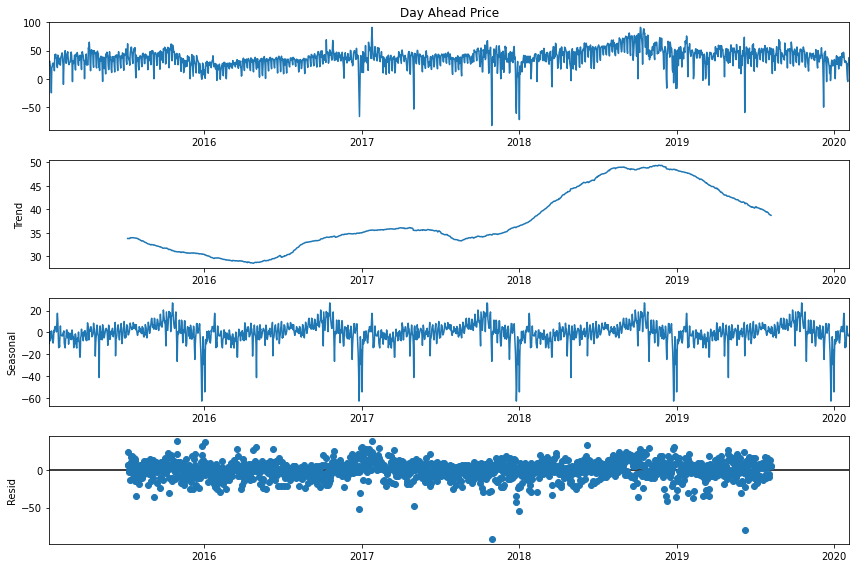

In [0]:
import statsmodels.api as sm

pdf = german_df.loc[german_df['Hour'] == 6, 'Day Ahead Price']

with mpl.rc_context():
  mpl.rc("figure", figsize=(12,8))
  sm.tsa.seasonal_decompose(pdf, freq=365).plot()
  result = sm.tsa.stattools.adfuller(pdf)

#### Autocorrelation of the time series

A very useful way to check seasonality is to see if there is a correlation of the time-series with its lagged version. The lags for which there is high correlation indicate a seasonality with that time-period. This is precisely the information encoded in an autocorrelation function which we will plot now.

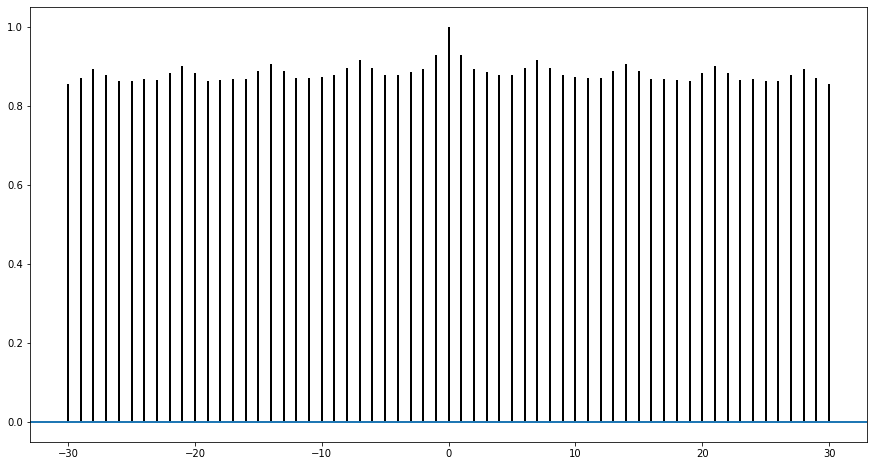

In [0]:
plt.figure(figsize=(15,8))
lags, c, _, _ = plt.acorr(german_df.sort_values(by='Date') \
  .loc[german_df['Hour'] == 5, 'Day Ahead Price'], usevlines=True, normed=True, maxlags=30, lw=2)

The plot above seems to indicate a slight weekly pattern.

In [0]:
ac_df = pd.DataFrame({'lags':lags, 'ac' : c})
highly_ac_list = ac_df.sort_values(by='ac', ascending=False).head(40)['lags'].to_list()
list(filter(lambda x: x>0, highly_ac_list)) # it is symmetric across a change in sign

[1, 7, 14, 21, 8, 6, 2, 28, 15, 13, 3, 22, 20, 4, 5, 9, 27, 10, 12]

#### Fourier space and the spectrum
If you come from a background in physics like I do, you are probably already screaming- why don't you operate on the *fourier space*? Yes, I hear you. Fourier decomposition is great at finding the seasonal and trend patterns in the data. Terms on the lower end of the spectrum (low frequency) can be interpreted as the ones which reveal the trend, while the ones on the higher end can be associated with seasons. It is also quite easy to distinguish the noise by identifying the low amplitude ones (and especially high frequency, low amplitude ones). This gives a very versatile method to deseasonalise/detrend/denoise the data.

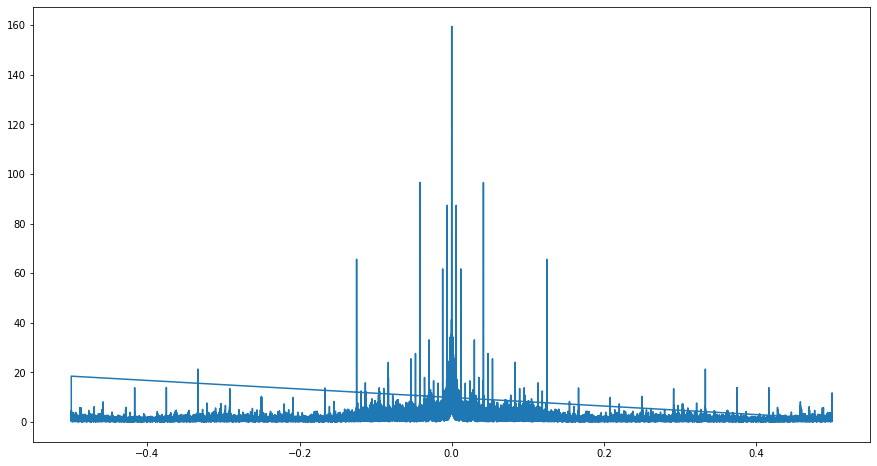

In [0]:
from numpy.fft import fft
from numpy.fft import fftfreq

ft = fft(german_df.sort_values(by='Date').loc[:, 'Day Ahead Price'])
ft_norm = list(map(lambda x: np.sqrt(x.real**2 + x.imag**2)/1000, ft))
freq = fftfreq(len(ft_norm))

plt.figure(figsize=(15,8))
plt.plot(freq[1:], ft_norm[1:])

#### Constructing lagged features

A typical way to incorporate non-local features into our dataset is to consider lagged features. The question then is what lag time should we consider?

# More on seasonality

In [0]:
german_df['Hour'] = german_df.index.hour
german_df['Day of Week'] = german_df.index.weekday
german_df['Day'] = german_df.index.day
german_df['Month'] = german_df.index.month
german_df['Year'] = german_df.index.year

## Daily patterns

There must be some daily patterns in the prices, cause the consumption- I am guessing- has similar patterns everyday especially on a regular workday. This obviously changes when it is a weekend, or a holiday, so let's see what the data has to say about daily patterns.

First up, let us look at an aggregrated data of prices grouped by time of day. We want to see mean usage over the day, and how much this varies across different dates. A box plot is well suited for this.

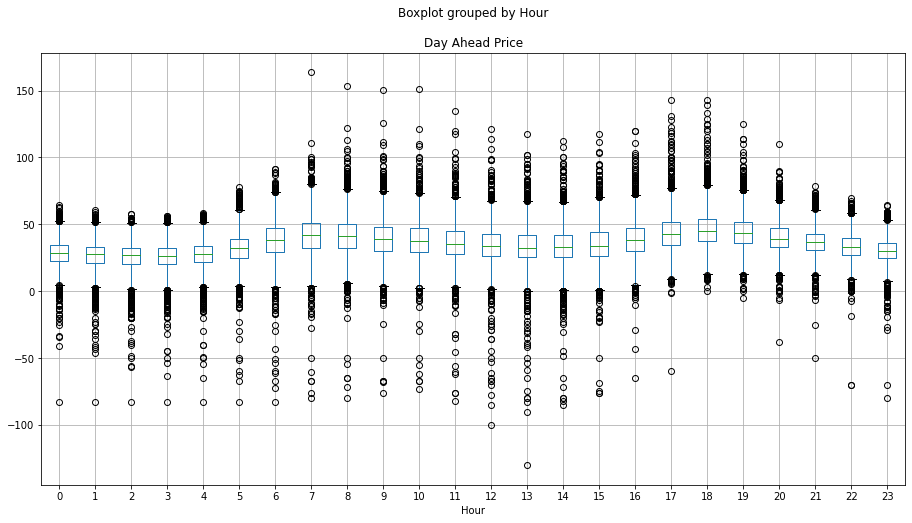

In [0]:
german_df.boxplot(column=['Day Ahead Price'], by='Hour', figsize=(15,8))

Seems like it has twin peaks of usage: typically around 8:00 and 19:00 each day. Sounds perfectly reasonable. Further, the variance in prices is more during 6:00 to 20:00, and lesser during the rest, especially the spikes in prices.

> Why are there negative values? Do they really pay to give away electricity in these intervals? Apparently they do, as weird as it might seem.

In [0]:
def plotDailyAheadPrice(date, color, axes, opacity=1):
  german_df['Hour'] = german_df['Hour'].astype('float')
  german_df[['Hour', 'Day Ahead Price']][german_df['Date'] == date] \
  .plot.line(
      'Hour', 'Day Ahead Price', 
       figsize=(15, 10), 
       color=color, 
       ax=axes, 
       legend=False,
       linestyle='--', 
       marker='o',
       alpha=opacity
  )

def quantilePlots(german_df, number_of_levels, opacity_threshold, color='grey'):
  """
    Prepare a plotted figure with the quantiles plotted as contours,
    as a reference for plotting further daily plots
  """
  grouped_by_hour = german_df[['Hour', 'Day Ahead Price']] \
  .groupby('Hour', as_index=False)

  # calculate mean by hour
  stat_df = grouped_by_hour.mean().copy()
  stat_df.rename(columns={'Day Ahead Price': 'mean'}, 
                 inplace=True)
  
  # calculate quantiles by hour
  for i in range(2*number_of_levels + 1):
    stat_df['q{}'.format(i)] = grouped_by_hour \
    .quantile(i / (2*number_of_levels)) \
    .loc[:, 'Day Ahead Price']

  # prepare matplot objects for plotting
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

  # plot quantile contours
  for i in range(number_of_levels):
    j = 2*number_of_levels - i
    alpha_level = opacity_threshold*((i+1)/(2*number_of_levels))
    plt.fill_between(
      stat_df['Hour'], stat_df['q{}'.format(i)], stat_df['q{}'.format(j)], 
      color=color, alpha=alpha_level
    )
    plt.plot(stat_df['Hour'], stat_df['q{}'.format(i)], color=color, alpha=0.1)
    plt.plot(stat_df['Hour'], stat_df['q{}'.format(j)], color=color, alpha=0.1)
  
  # plot mean
  plt.plot(stat_df['Hour'], stat_df['q{}'.format(number_of_levels)], 
           color=color, 
           linewidth=3,
           alpha=opacity_threshold)

  return axes

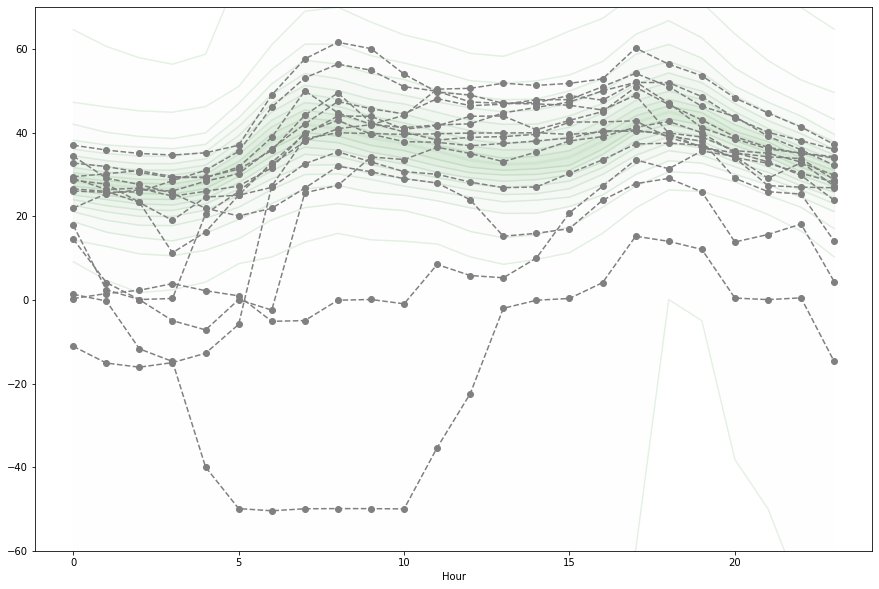

In [0]:
def dateRange(startDate, endDate):
  currentDate = startDate
  while (endDate > currentDate):
    currentDate = currentDate + dt.timedelta(days=1)
    yield currentDate

axes2 = quantilePlots(german_df, 10, 0.05, color='green')
plt.ylim(top=70, bottom=-60)

starting = dt.datetime(2019, 12, 6)
until = dt.datetime(2019, 12, 20)
for date in dateRange(starting, until):
  plotDailyAheadPrice(date, 'grey', axes2)

In [0]:
weekly_df = german_df.groupby(['Day of Week', 'Hour'], as_index=False).mean()

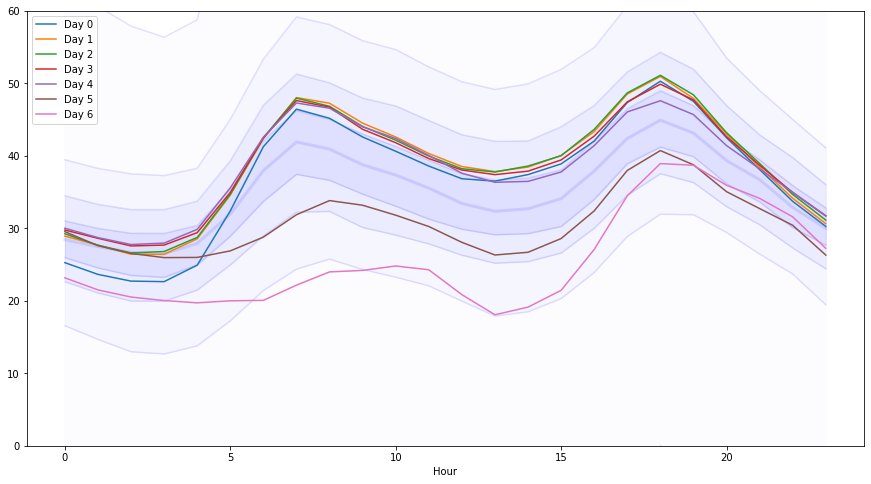

In [0]:
axes = quantilePlots(german_df, 4, 0.1, 'blue')
plt.ylim(top=60, bottom=0)
for day in range(7):
  weekly_df[weekly_df['Day of Week'] == day] \
  .rename(columns={'Day Ahead Price' : 'Day ' + str(day)}) \
  .plot.line('Hour', 'Day ' + str(day), ax=axes)

## Weekly patterns

Sundays and Saturdays are off; does that lead to a change in pattern for those days?

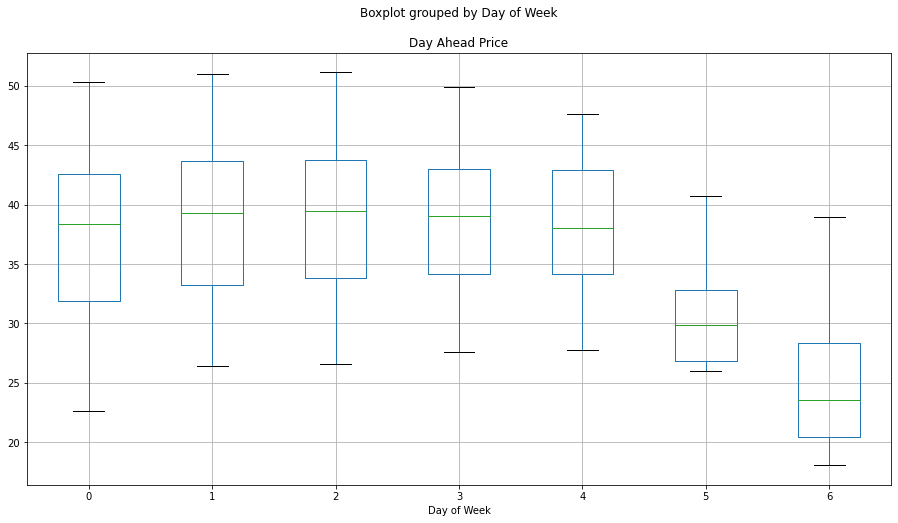

In [0]:
weekly_df.boxplot(column=['Day Ahead Price'], by='Day of Week', figsize=(15,8))

## Monthly patterns

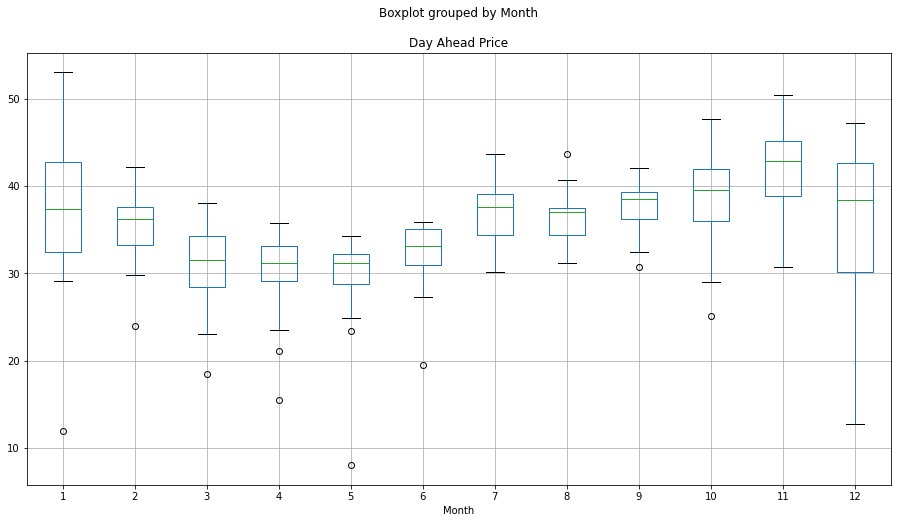

In [0]:
german_df.groupby(['Day', 'Month'], as_index=False).mean() \
  .boxplot(column=['Day Ahead Price'], by='Month', figsize=(15,8))

## Annual patterns

Seasonality (by which I literally mean the seasons such as winter, summer and so on) influence energy consumption and generation.

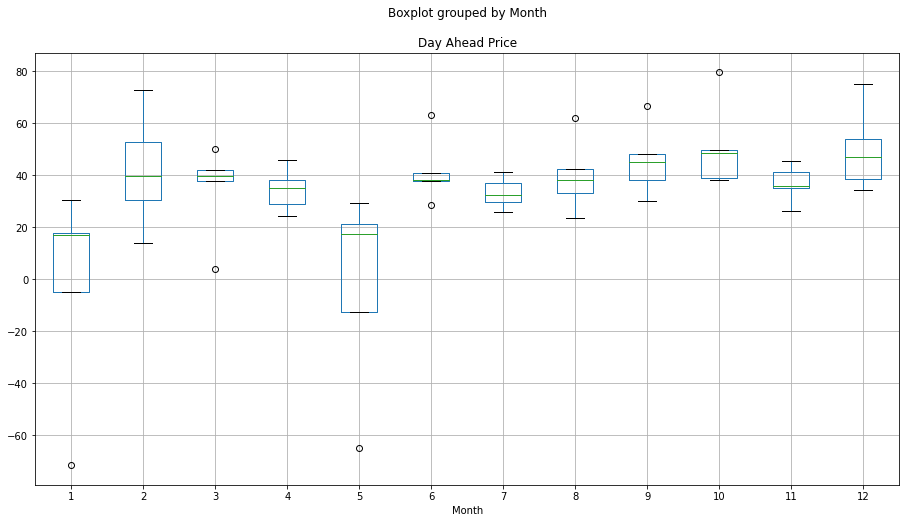

In [0]:
german_df[(german_df['Hour'] == 8) & (german_df['Day'] == 1)] \
.boxplot(column=['Day Ahead Price'], by='Month', figsize=(15,8))

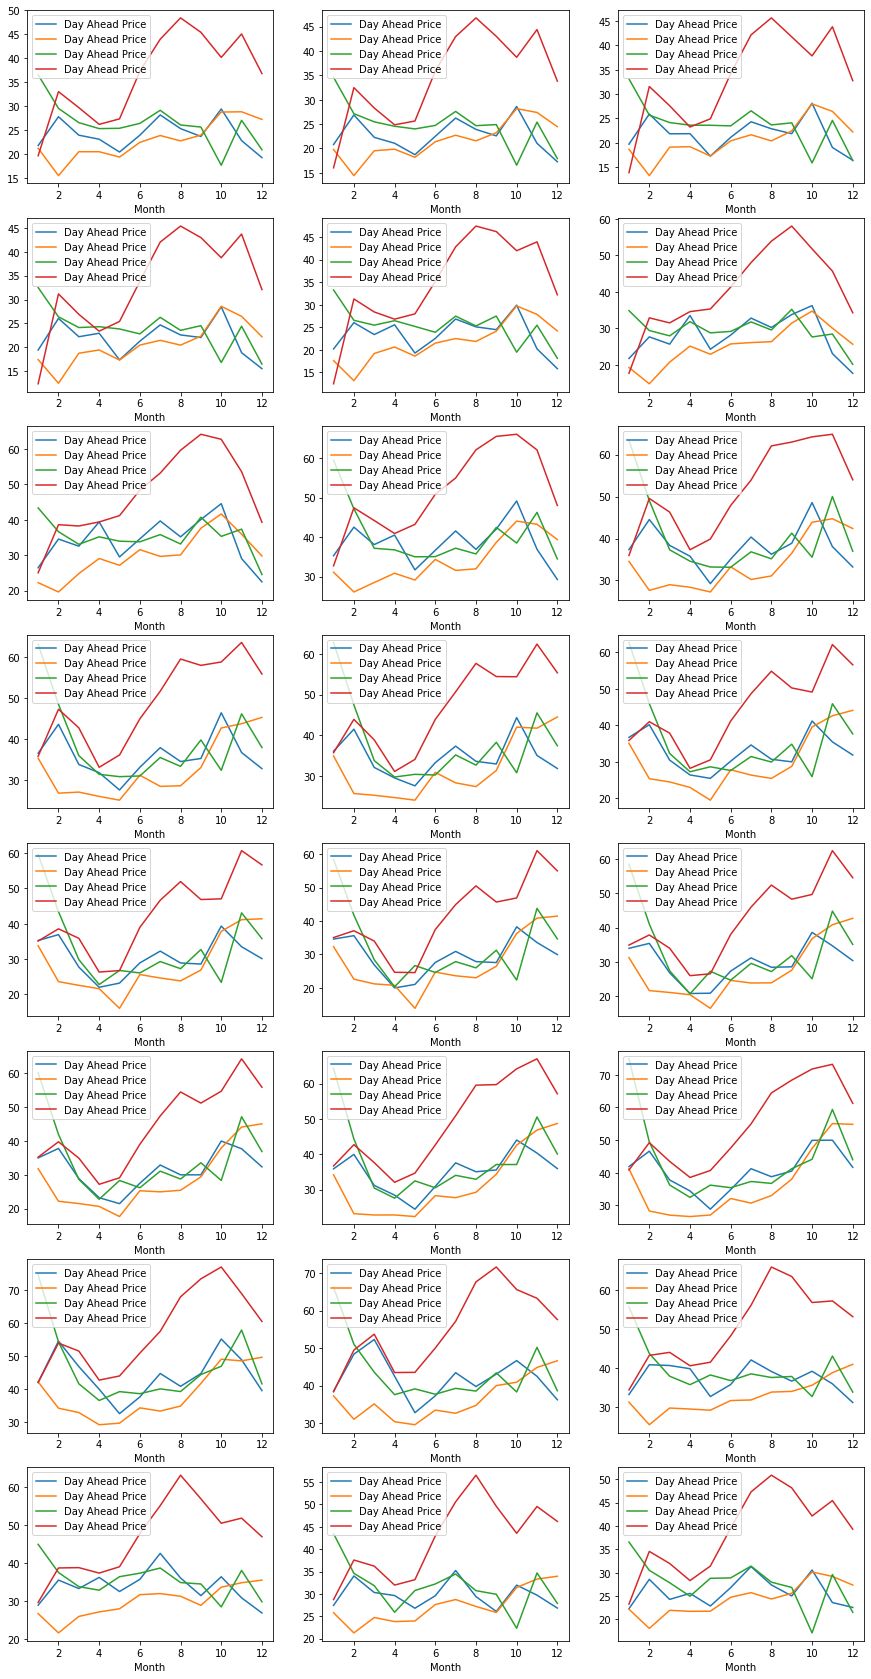

In [0]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(15,30))

for h in range(24):
  german_df_monthly = german_df[german_df['Hour'] == h].groupby(['Month', 'Year'], as_index=False).mean()
  for y in range(2015, 2019):
    german_df_monthly[german_df_monthly['Year'] == y].plot('Month', 'Day Ahead Price', ax=axes[h//3,h%3])

# Holidays and other predictable spikes

**Holidays** are slightly more complicated than just being a seasonal pattern. Some holidays are based on the lunar calendar, while some change (like Easter) from year to year based on other conditions. But whether a day is a holiday or not affects demand, so it is useful to include this feature in our analysis. A quick search reveals python packages called `Holidays` and `Workalendar`; I would prefer to implement my own version, but due to time constraints, I have chosen `Workalendar`.

In [0]:
from workalendar.registry import registry
from collections import defaultdict

from_year = 2014
to_year = 2020

# our bidding zone consists of Austria (pre-2018), Germany and Luxembourg
calendars = registry.get_calendars(['AT', 'DE', 'LU'], include_subregions=True)
holidayDict = defaultdict(list)
countrySet = set()
for country, calendar in calendars.items():
  countrySet.add(country)
  temp_obj = calendar()
  for year in range(from_year, to_year):
    for holidayDate, holidayName in temp_obj.holidays(year):
      holidayDict[holidayDate].append((holidayName, country))

def get_holiday(chosenDate, region):
  holidays_on_date = holidayDict[chosenDate]
  for holiday, region_of_holiday in holidays_on_date:
    if region_of_holiday == region:
      return holiday
  return 'normal day'

for country in countrySet:
  german_df[country] = german_df['Date'].apply(lambda x: get_holiday(x.date(), country))

Let's plot an aggregrate plot of holidays vs. working days to see how much of an effect this feature really has.

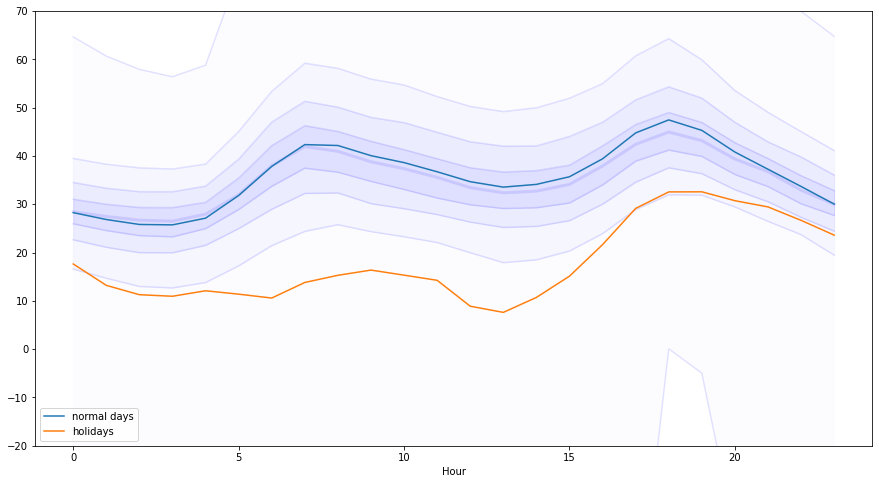

In [0]:
axes = quantilePlots(german_df, 4, 0.1, 'blue')

plt.ylim(top=70, bottom=-20)

german_df[german_df['DE'] == 'normal day'] \
  .groupby('Hour', as_index=False) \
  .mean() \
  .rename(columns={'Day Ahead Price' : 'normal days'}) \
  .plot('Hour', 'normal days', ax=axes)

german_df[german_df['DE'] != 'normal day'] \
  .groupby('Hour', as_index=False) \
  .mean() \
  .rename(columns={'Day Ahead Price' : 'holidays'}) \
  .plot('Hour', 'holidays', ax=axes)

That plot should convince you that accounting for holidays was indeed a good idea.

# [Sunrise and sunset]

Todo
Does daylight affect electricity consumption?

In [0]:
from astral import LocationInfo
from astral.sun import sun

city = LocationInfo("Berlin", "Germany", "Europe/Berlin", 52.5, 13.40)
s = sun(city.observer, date=dt.date(2020, 2, 28))
s['sunrise'].time()
s['sunset']

datetime.datetime(2020, 2, 28, 16, 42, 8, 140387, tzinfo=<UTC>)

# Exogenous series

Until now, we have only considered features extracted from the time-series itself. For the next part, we want to consider exogenous time-series that can be considered in our analysis.

#### Day-ahead load and generation forecasts

Load and generation forecasts are given before the day-ahead prices are set, so they represent important features for estimating the day-ahead price. Further, picking up from ref. B.[2], it can even be argued that weather data and other features are already considered in this datapoint, so one can even forego considering those in favour of this. This is indeed the approach that I will take, but first it needs a bit of cleaning before it is useful.

##### Generation forecast

In [0]:
root_path = 'energy-prediction/data/Germany/generation-forecast/'
genForecastDF1 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201501010000_201701012359_1.csv'), sep=';')
genForecastDF2 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201701010000_201901012359_1.csv'), sep=';')
genForecastDF3 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201901010000_202101012359_1.csv'), sep=';')

genForecastDF = genForecastDF1 \
  .append(genForecastDF2[genForecastDF2['Date'] != 'Jan 1, 2017']) \
  .append(genForecastDF3[genForecastDF3['Date'] != 'Jan 1, 2019'])

genForecastDF['Date'] = pd.to_datetime(genForecastDF['Date'])
genForecastDF['Time of day'] = pd.to_datetime(genForecastDF['Time of day']).dt.time
genForecastDF.replace('-', 'NaN', inplace=True)
for column in list(filter(lambda x: x.endswith('[MWh]'), genForecastDF.columns)):
  genForecastDF[column] = genForecastDF[column].apply(lambda x: float(x.replace(',', '')))

genForecastDF['timedate'] = pd.to_datetime(genForecastDF['Date'].astype('str') + ' ' + genForecastDF['Time of day'].astype('str'))
genForecastDF.set_index('timedate', drop=True, inplace=True)
genForecastDF.index.name = None

genForecastDF.sort_index(inplace=True) # so that accessing by key is possible

# correct for daylight savings time
change_dict = {}
for d1, d2 in daylight_savings_ranges:
  previous_index = (genForecastDF.loc[d1:d2, 'Time of day'].index)
  modified_index = previous_index - pd.to_timedelta(1, unit='h')
  change_dict.update(zip(previous_index, modified_index))

corrected_genForecastDF = genForecastDF.rename(index=change_dict)
new_index = corrected_genForecastDF.index \
  .where(~corrected_genForecastDF.index.duplicated(), corrected_genForecastDF.index + pd.to_timedelta(1, unit='h'))
corrected_genForecastDF.set_index(new_index, inplace=True)
corrected_genForecastDF['Time of day'] = corrected_genForecastDF.index.time
corrected_genForecastDF['Date'] = pd.to_datetime(corrected_genForecastDF.index.date)

# add a column to indicate this change
corrected_genForecastDF['Daylight Savings Time'] = 0
corrected_genForecastDF.loc[change_dict.values(), 'Daylight Savings Time'] = 1

corrected_genForecastDF.sample(5)

,Date,Time of day,Total[MWh],Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],Other[MWh],Daylight Savings Time
2018-07-18 06:45:00,2018-07-18,06:45:00,NaN,226.75,1797.25,1522.75,NaN,1
2018-09-04 01:30:00,2018-09-04,01:30:00,NaN,304.50,1402.50,0.00,NaN,1
2017-11-08 11:45:00,2017-11-08,11:45:00,NaN,43.00,507.00,969.00,NaN,0
2017-12-28 03:45:00,2017-12-28,03:45:00,NaN,591.00,2611.00,0.00,NaN,0
2016-10-14 12:45:00,2016-10-14,12:45:00,NaN,785.00,3304.00,3374.00,NaN,1


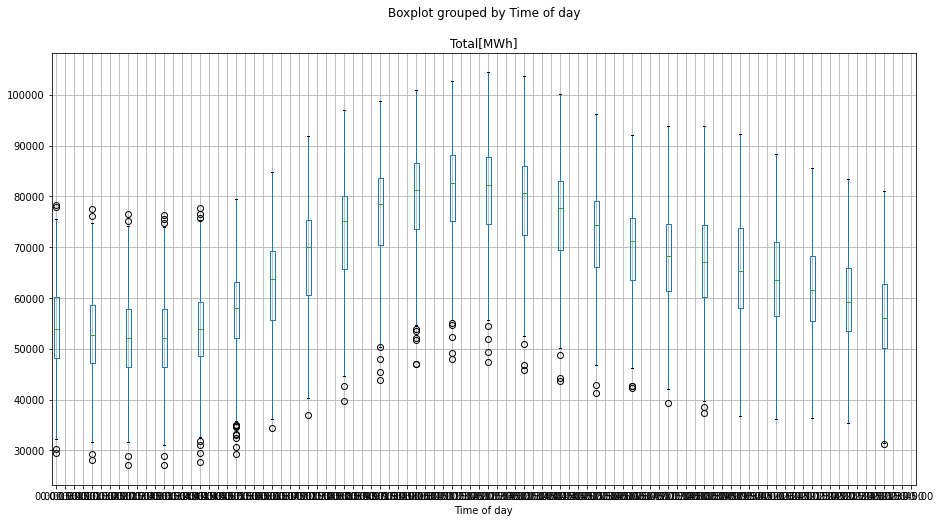

In [0]:
corrected_genForecastDF.boxplot('Total[MWh]', by='Time of day', figsize=(15,8))

##### Load forecast

In [0]:
root_path = 'energy-prediction/data/Germany/load-forecast/'
loadForecastDF1 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201501010000_201701012345_1.csv'), sep=';')
loadForecastDF2 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201701010000_201901012345_1.csv'), sep=';')
loadForecastDF3 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201901010000_202002082345_1.csv'), sep=';')
loadForecastDF = loadForecastDF1 \
  .append(loadForecastDF2[loadForecastDF2['Date'] != 'Jan 1, 2017']) \
  .append(loadForecastDF3[loadForecastDF3['Date'] != 'Jan 1, 2019'])

loadForecastDF['Date'] = pd.to_datetime(loadForecastDF['Date'])
loadForecastDF['Time of day'] = pd.to_datetime(loadForecastDF['Time of day']).dt.time
loadForecastDF.replace('-', 'NaN', inplace=True)
for column in list(filter(lambda x: x.endswith('[MWh]'), loadForecastDF.columns)):
  loadForecastDF[column] = loadForecastDF[column].apply(lambda x: float(x.replace(',', '')))

# set key to datetime
loadForecastDF['timedate'] = pd.to_datetime(loadForecastDF['Date'] \
                                .astype('str') + ' ' + loadForecastDF['Time of day'].astype('str'))
loadForecastDF.set_index('timedate', drop=True, inplace=True)
loadForecastDF.index.name = None

loadForecastDF.sort_index(inplace=True) # so that accessing by key is possible

# correct for daylight savings time
change_dict = {}
for d1, d2 in daylight_savings_ranges:
  previous_index = (loadForecastDF.loc[d1:d2, 'Time of day'].index)
  modified_index = previous_index - pd.to_timedelta(1, unit='h')
  change_dict.update(zip(previous_index, modified_index))

corrected_loadForecastDF = loadForecastDF.rename(index=change_dict)
new_index = corrected_loadForecastDF.index \
  .where(~corrected_loadForecastDF.index.duplicated(), corrected_loadForecastDF.index + pd.to_timedelta(1, unit='h'))
corrected_loadForecastDF.set_index(new_index, inplace=True)
corrected_loadForecastDF['Time of day'] = corrected_loadForecastDF.index.time
corrected_loadForecastDF['Date'] = pd.to_datetime(corrected_loadForecastDF.index.date)

# add a column to indicate this change
corrected_loadForecastDF['Daylight Savings Time'] = 0
corrected_loadForecastDF.loc[change_dict.values(), 'Daylight Savings Time'] = 1

corrected_loadForecastDF.sample(5)

,Date,Time of day,Total[MWh],Daylight Savings Time
2019-09-21 20:15:00,2019-09-21,20:15:00,11674.00,1
2018-08-16 11:45:00,2018-08-16,11:45:00,16506.75,1
2019-06-13 05:15:00,2019-06-13,05:15:00,12878.00,1
2015-03-18 04:45:00,2015-03-18,04:45:00,11998.50,0
2018-02-26 18:45:00,2018-02-26,18:45:00,17643.00,0


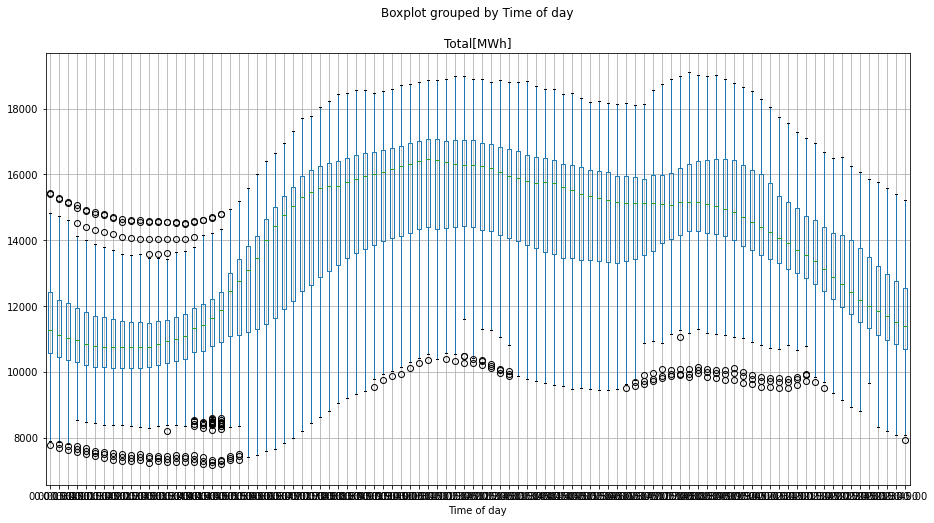

In [0]:
corrected_loadForecastDF.boxplot('Total[MWh]', by='Time of day', figsize=(15,8))

##### Combining the datasets

We want to join these datasets to the `german_df` that we have. But note that it has a different resolution from the price dataset: the load and generation forecast are given for every 15 minutes, while the prices are given hourly. For simplicity and a lack of better idea, I will just take the hourly average for the load and generation forecast.

In [0]:
groupedLoad = corrected_loadForecastDF \
  .groupby([corrected_loadForecastDF.index.date, corrected_loadForecastDF.index.hour])
load_to_joinDF = groupedLoad.agg({
    'Total[MWh]' : 'mean',
    'Date' : 'min',
    'Time of day' : 'min'
})

load_to_joinDF['timedate'] = pd.to_datetime(load_to_joinDF['Date'] \
                                            .astype('str') + ' ' + load_to_joinDF['Time of day'].astype('str'))
load_to_joinDF.set_index('timedate', drop=True, inplace=True)
load_to_joinDF.index.name = None

groupedGen = corrected_genForecastDF \
  .groupby([corrected_genForecastDF.index.date, corrected_genForecastDF.index.hour])
gen_to_joinDF = groupedGen.agg({
    'Total[MWh]' : 'mean',
    'Wind offshore[MWh]' : 'mean',
    'Wind onshore[MWh]' : 'mean',
    'Photovoltaics[MWh]' : 'mean',
    'Other[MWh]' : 'mean',
    'Date' : 'min',
    'Time of day' : 'min'
})

gen_to_joinDF['timedate'] = pd.to_datetime(gen_to_joinDF['Date'] \
                                           .astype('str') + ' ' + gen_to_joinDF['Time of day'].astype('str'))
gen_to_joinDF.set_index('timedate', drop=True, inplace=True)
gen_to_joinDF.index.name = None

In [0]:
load_to_joinDF.rename(columns={'Total[MWh]' : 'Total Load'}, inplace=True)
power_sources = list(filter(lambda x: x.endswith('[MWh]'), sorted(gen_to_joinDF)))
renamed_power_sources = list(map(lambda x: x[:-5] + ' Generation', power_sources))

gen_to_joinDF.rename(columns=dict(zip(power_sources, renamed_power_sources)), inplace=True)

In [0]:
# does an inner join
columns_for_join = {
    'load' : 'Total Load',
    'gen' : renamed_power_sources
}
german_df_with_load = german_df \
  .join(load_to_joinDF[columns_for_join['load']])
german_df_with_load_and_gen = german_df_with_load. \
  join(gen_to_joinDF[columns_for_join['gen']])

In [0]:
german_df_with_load_and_gen.sample(5)

,Date,Time of day,Daylight Savings Time,Day Ahead Price,Bidding Zone,Hour,Day of Week,Day,Month,Year,DE-MV,DE,DE-SL,DE-SH,DE-BE,DE-HB,DE-ST,DE-TH,DE-HH,DE-NI,DE-HE,LU,AT,DE-RP,DE-SN,DE-NW,DE-BY,DE-BB,DE-BW,Total Load,Other Generation,Photovoltaics Generation,Total Generation,Wind offshore Generation,Wind onshore Generation
2018-04-22 19:00:00,2018-04-22,19:00:00,1,36.96,DE-AT-LU,19.0,6,22,4,2018,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,12410.5625,31591.75,18.75,41599.0,620.875,1862.1875
2016-09-09 16:00:00,2016-09-09,16:00:00,1,35.89,DE-AT-LU,16.0,4,9,9,2016,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,14434.5000,63064.00,1998.00,72586.0,155.000,227.7500
2019-08-19 16:00:00,2019-08-19,16:00:00,1,33.06,DE-LU,16.0,0,19,8,2019,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,14744.7500,45101.00,2430.00,71006.0,956.750,3090.0000
2016-11-19 22:00:00,2016-11-19,22:00:00,0,32.14,DE-AT-LU,22.0,5,19,11,2016,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,normal day,12865.9375,45348.00,0.00,61403.0,693.500,3320.2500
2016-01-06 17:00:00,2016-01-06,17:00:00,0,44.95,DE-AT-LU,17.0,2,6,1,2016,normal day,normal day,normal day,normal day,normal day,normal day,Epiphany,normal day,normal day,normal day,normal day,normal day,Epiphany,normal day,normal day,normal day,Epiphany,normal day,Epiphany,15171.9375,66192.00,0.50,73246.0,615.250,1147.7500


##### Imputation strategy

In [0]:
corrected_loadForecastDF[corrected_loadForecastDF['Total[MWh]'].isna()]

,Date,Time of day,Total[MWh],Daylight Savings Time
2015-09-25 23:00:00,2015-09-25,23:00:00,NaN,1
2015-09-25 23:15:00,2015-09-25,23:15:00,NaN,1
2015-09-25 23:30:00,2015-09-25,23:30:00,NaN,1
2015-09-25 23:45:00,2015-09-25,23:45:00,NaN,1
2015-09-26 00:00:00,2015-09-26,00:00:00,NaN,1
...,...,...,...,...
2020-01-31 22:45:00,2020-01-31,22:45:00,NaN,0
2020-01-31 23:00:00,2020-01-31,23:00:00,NaN,0
2020-01-31 23:15:00,2020-01-31,23:15:00,NaN,0
2020-01-31 23:30:00,2020-01-31,23:30:00,NaN,0


#### Cross correlation to price

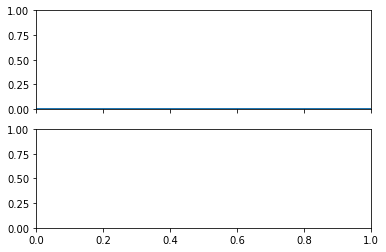

In [0]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
x1 = ax1.xcorr(german_df_with_load_and_gen['Day Ahead Price'],
          german_df_with_load_and_gen['Total Load'], 
          usevlines=True, maxlags=50, normed=True, lw=2)

# How do neighbouring markets affect the price?

The importance of accounting for neighbouring market prices is well described in `[LRV18]`.

# Conclusion
That's it. We finally save it in `hdf` format for later use.

In [0]:
german_df.to_hdf('clean_german_df')

# Bibliography
 
**[You12]** Electricity storage is not possible efficiently at a large scale yet, but there are some interesting ideas out there for sure. For example, see flywheels: https://www.youtube.com/watch?v=7K4W4hA6aV4.

**[LRV18]** J. Lago, F. D. Ridder, P. Vrancx, B. D. Schutter, *Forecasting day-ahead electricity prices in Europe: the importance of considering market integration*, Applied Energy 211 (2018) 890-903.

**[SMARD].** https://www.smard.de/en/topic-article/5870/9846   

Next part: [Statistical models]()